In [ ]:
import tensorflow.keras
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import random
import seaborn as sns

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers import *
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import multilabel_confusion_matrix,roc_auc_score,confusion_matrix

import warnings
warnings.filterwarnings("ignore")

2023-02-07 14:49:11.284385: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [ ]:
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training/'
train_paths = []
for label in os.listdir(train_dir):
    for file in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+file)
random.shuffle(train_paths)
# show an example of the list
print(train_paths[0])

/kaggle/input/brain-tumor-mri-dataset/Training/glioma/Tr-gl_0948.jpg


In [ ]:
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing/'
test_paths = []
for label in os.listdir(test_dir):
    for file in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+file)
random.shuffle(test_paths)
# show an example of the list
print(test_paths[0])

/kaggle/input/brain-tumor-mri-dataset/Testing/notumor/Te-no_0303.jpg


In [ ]:
len(test_paths)

1311

In [ ]:
train_data = []
train_labels = []

test_data = []
test_labels = []

In [ ]:
# loop over the image paths
for imagePath in train_paths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    
    # load the input image (224x224) and preprocess it
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = np.array(image)/255.0
    
    # update the data and labels lists, respectively
    train_data.append(image)
    train_labels.append(label)

In [ ]:
# loop over the image paths
for imagePath in test_paths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    
    # load the input image (224x224) and preprocess it
    image = load_img(imagePath, target_size=(224, 224))
    
    image = img_to_array(image)
    image = np.array(image)/255.0
    
    # update the data and labels lists, respectively
    test_data.append(image)
    test_labels.append(label)

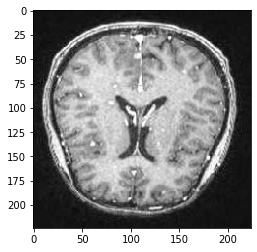

In [ ]:
plt.imshow(test_data[2])

In [ ]:

def convert_data_labels(data,labels):
  # convert the data and labels to NumPy arrays
  data = np.array(data, dtype="float32")
  labels = np.array(labels)

  # perform one-hot encoding on the labels
  le = LabelEncoder()
  labels = le.fit_transform(labels)
  labels_to_index=dict(zip(le.classes_, le.transform(le.classes_)))
  labels = to_categorical(labels)
  return  data,labels,labels_to_index

# Class Distribution

<AxesSubplot:>

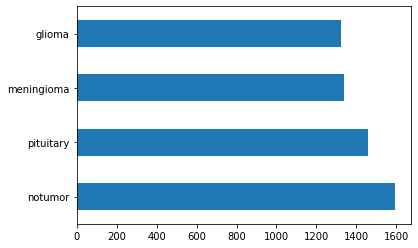

In [ ]:
pd.Series(train_labels).value_counts().plot(kind='barh')

<AxesSubplot:>

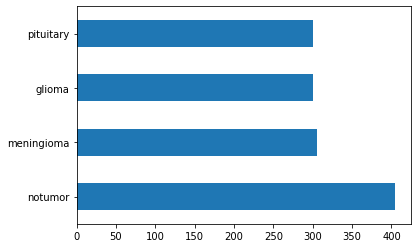

In [ ]:
pd.Series(test_labels).value_counts().plot(kind='barh')

In [ ]:
train_data,train_labels,labels_to_index = convert_data_labels(train_data,train_labels)
test_data,test_labels ,_= convert_data_labels(test_data,test_labels)

In [ ]:
print("Size of train dataset : ",train_data.shape)
print("==================================")
print("Size of test dataset : ",test_data.shape)
print("==================================")

Size of train dataset :  (5712, 224, 224, 3)
Size of test dataset :  (1311, 224, 224, 3)


In [ ]:
labels_to_index

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [ ]:
index_to_labels={}
for label,value in enumerate(labels_to_index):
    index_to_labels[label]=value

In [ ]:
index_to_labels

{0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}

# Image generator

In [ ]:
BS=32

# train datagen
train_datagen = ImageDataGenerator(
#                   rescale = 1/255,
                  validation_split=0.25
)


# test datagen
test_datagen = ImageDataGenerator(
#                     rescale = 1/255
)

train_gen = train_datagen.flow(train_data, train_labels, batch_size=BS,subset="training")

val_gen = train_datagen.flow(train_data, train_labels, batch_size=BS,subset="validation")

test_gen = train_datagen.flow(test_data, test_labels, batch_size=BS)


In [ ]:
train_labels[0]

array([1., 0., 0., 0.], dtype=float32)

# Transfer learning

In [ ]:
resnet_model = ResNet50(weights='imagenet', input_shape=(224,224,3), include_top=False)
# Set all layers to non-trainable
for layer in resnet_model.layers[:171]:
    layer.trainable = False

for layer in resnet_model.layers[171:]:
    layer.trainable = True

2023-02-07 14:50:26.983785: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-07 14:50:26.987321: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-02-07 14:50:27.047008: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-07 14:50:27.047713: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2023-02-07 14:50:27.047781: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-02-07 14:50:27.076637: I tensorflow/stream_executor/platform/def

94773248/94765736 [==============================] - 0s 0us/step


In [ ]:
model = Sequential()
model.add(Input(shape=(224,224,3)))
model.add(resnet_model)
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax')) # num labels = 4

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dropout (Dropout)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               12845184  
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 516       
Total params: 36,433,412
Trainable params: 13,900,420
Non-trainable params: 22,532,992
___________________________________

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=['accuracy','AUC'])

In [ ]:

history=model.fit(train_gen, 
          epochs=15,
          validation_data=val_gen
         )

2023-02-07 14:50:31.472572: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-02-07 14:50:31.476786: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000140000 Hz


Epoch 1/15


2023-02-07 14:50:34.452402: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-02-07 14:50:35.246017: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2023-02-07 14:50:35.281230: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


134/134 [==============================] - 24s 107ms/step - loss: 1.2127 - accuracy: 0.5593 - auc: 0.7899 - val_loss: 1.0281 - val_accuracy: 0.3831 - val_auc: 0.8209
Epoch 2/15
134/134 [==============================] - 12s 90ms/step - loss: 0.6440 - accuracy: 0.7329 - auc: 0.9274 - val_loss: 0.8294 - val_accuracy: 0.6310 - val_auc: 0.8773
Epoch 3/15
134/134 [==============================] - 12s 92ms/step - loss: 0.5505 - accuracy: 0.7857 - auc: 0.9466 - val_loss: 0.5080 - val_accuracy: 0.8326 - val_auc: 0.9615
Epoch 4/15
134/134 [==============================] - 12s 91ms/step - loss: 0.4858 - accuracy: 0.8102 - auc: 0.9583 - val_loss: 0.4117 - val_accuracy: 0.8529 - val_auc: 0.9723
Epoch 5/15
134/134 [==============================] - 12s 91ms/step - loss: 0.4401 - accuracy: 0.8257 - auc: 0.9653 - val_loss: 0.5160 - val_accuracy: 0.8018 - val_auc: 0.9544
Epoch 6/15
134/134 [==============================] - 12s 92ms/step - loss: 0.4250 - accuracy: 0.8381 - auc: 0.9679 - val_loss: 0.

In [ ]:
import tensorflow.compat.v2 as tf
xception_model= tf.keras.applications.Xception(
    weights="imagenet",
    input_shape=(224,224,3),
    include_top=False,
)

83689472/83683744 [==============================] - 1s 0us/step


In [ ]:

for layer in xception_model.layers[:171]:
    layer.trainable = False

for layer in xception_model.layers[171:]:
    layer.trainable = True

In [ ]:
model = Sequential()
model.add(Input(shape=(224,224,3)))
model.add(xception_model)
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax')) # num labels = 4

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 100352)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               12845184  
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 516       
Total params: 33,707,180
Trainable params: 12,845,700
Non-trainable params: 20,861,480
_________________________________

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=['accuracy','AUC'])

In [ ]:
history=model.fit(train_gen, 
          epochs=15,
          validation_data=val_gen
         )

Epoch 1/15
134/134 [==============================] - 19s 121ms/step - loss: 0.8956 - accuracy: 0.7155 - auc: 0.8898 - val_loss: 0.3112 - val_accuracy: 0.8985 - val_auc: 0.9826
Epoch 2/15
134/134 [==============================] - 15s 112ms/step - loss: 0.2573 - accuracy: 0.9011 - auc: 0.9873 - val_loss: 0.2349 - val_accuracy: 0.9118 - val_auc: 0.9896
Epoch 3/15
134/134 [==============================] - 15s 111ms/step - loss: 0.1697 - accuracy: 0.9406 - auc: 0.9946 - val_loss: 0.2035 - val_accuracy: 0.9244 - val_auc: 0.9917
Epoch 4/15
134/134 [==============================] - 15s 111ms/step - loss: 0.1105 - accuracy: 0.9629 - auc: 0.9979 - val_loss: 0.2268 - val_accuracy: 0.9202 - val_auc: 0.9896
Epoch 5/15
134/134 [==============================] - 15s 111ms/step - loss: 0.1002 - accuracy: 0.9636 - auc: 0.9981 - val_loss: 0.2486 - val_accuracy: 0.9090 - val_auc: 0.9888
Epoch 6/15
134/134 [==============================] - 15s 111ms/step - loss: 0.0777 - accuracy: 0.9740 - auc: 0.999

# model evaluation

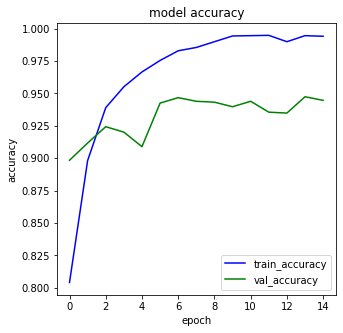

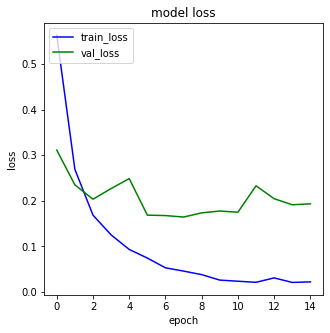

In [ ]:
plt.figure(figsize=(5,5))
# summarize history for accuracy
hist=history.history
plt.plot(hist["accuracy"],color="b",label="train_accuracy")
plt.plot(hist["val_accuracy"],color="g",label="val_accuracy")
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc="lower right")
plt.show()

plt.figure(figsize=(5,5))
# summarize history for loss
plt.plot(hist['loss'],color="b",label="train_loss")
plt.plot(hist['val_loss'],color="g",label="val_loss")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend( loc='upper left')
plt.show()

In [ ]:
model.evaluate(train_gen)

134/134 [==============================] - 11s 82ms/step - loss: 0.0087 - accuracy: 0.9988 - auc: 1.0000


[0.008661121129989624, 0.9988328814506531, 0.9999992251396179]

In [ ]:
model.evaluate(val_gen)

45/45 [==============================] - 4s 82ms/step - loss: 0.1933 - accuracy: 0.9447 - auc: 0.9906


[0.19331350922584534, 0.9446778893470764, 0.9905877709388733]

In [ ]:
model.evaluate(test_gen)

41/41 [==============================] - 4s 90ms/step - loss: 0.1899 - accuracy: 0.9466 - auc: 0.9922


[0.18992674350738525, 0.9466056227684021, 0.9922171235084534]

In [ ]:
test_pred=model.predict(test_gen)

In [ ]:
test_pred

array([[3.1157190e-04, 9.9968612e-01, 1.5738595e-06, 7.9669002e-07],
       [5.3163636e-01, 4.6482569e-01, 1.1294244e-04, 3.4250303e-03],
       [1.5026401e-05, 9.9998343e-01, 1.3677279e-06, 2.0825237e-07],
       ...,
       [9.6552461e-01, 3.3656668e-02, 8.0043270e-04, 1.8237806e-05],
       [3.1259728e-10, 8.9333253e-06, 9.9998963e-01, 1.3782045e-06],
       [6.2951315e-03, 9.9370378e-01, 1.0730479e-06, 2.8406257e-08]],
      dtype=float32)

In [ ]:
# # converting prediction to one-hot vector
# for i in range(len(test_pred)):
#     ind=np.argmax(test_pred[i])
#     test_pred[i]=0.0
#     test_pred[i][ind]=1.0

In [ ]:
#finding the class by np.argmax() from each prediction
test_pred_class=[]
test_labels_class=[]
for i,pred in enumerate(test_pred):
    test_pred_class.append(np.int(np.argmax(pred)))
    
for i,pred in enumerate(test_labels):
    test_labels_class.append(np.int(np.argmax(pred)))

In [ ]:
# print(test_pred_class)

In [ ]:
# print(test_labels_class)

In [ ]:
labels=list(index_to_labels.values())
labels

['glioma', 'meningioma', 'notumor', 'pituitary']

In [ ]:
cm = confusion_matrix(test_labels_class, test_pred_class)

# Confusion matrix

In [ ]:
import itertools
from itertools import product
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


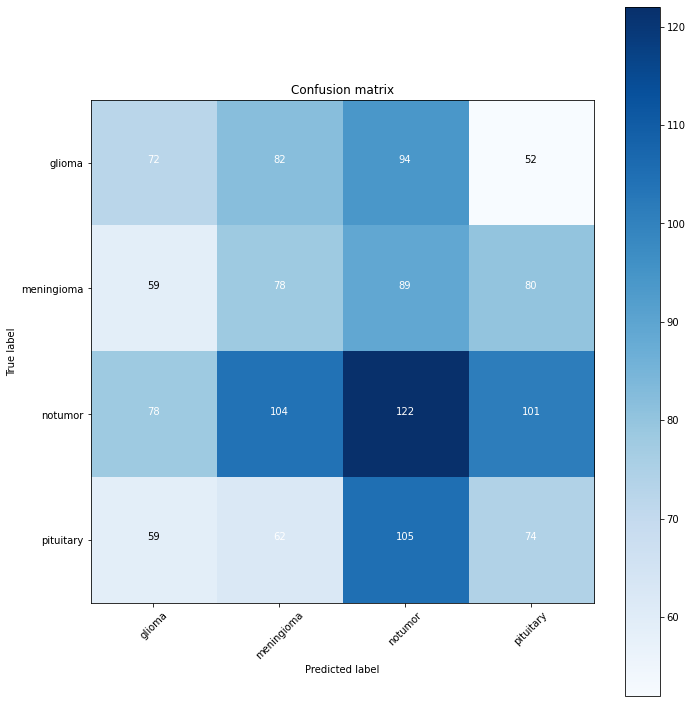

In [ ]:
plot_confusion_matrix(cm,labels)

In [ ]:
AUC=roc_auc_score(test_labels,test_pred)
AUC

0.5105557144681827

In [ ]:
# sns.heatmap(cm, annot=True)

In [ ]:
path_to_label={}
for i,path in enumerate(test_paths):
    label = path.split(os.path.sep)[-2]
    path_to_label[path]=label


# Model Prediction

In [ ]:
predictions=model.predict(test_gen)

In [ ]:
from PIL import Image

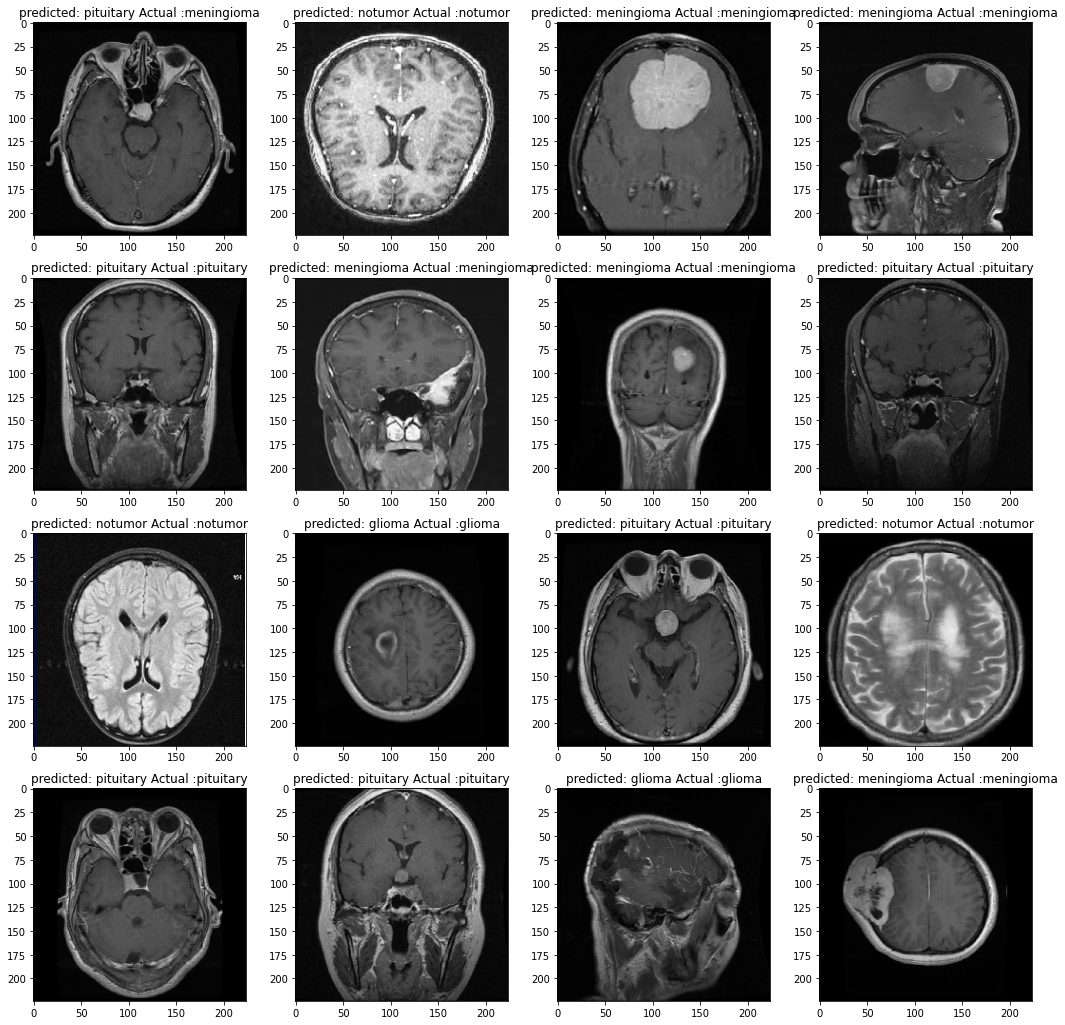

In [ ]:
fig = plt.figure(figsize=(18, 18))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
    img = load_img(test_paths[i], target_size=(224, 224))
    img = img_to_array(img)
    img = np.array(img)/255.0
    img=np.reshape(img,(-1,224,224,3))
    pred=model.predict(img)
    index=np.argmax(pred)
    klass=index_to_labels[index] 
    actual=path_to_label[test_paths[i]]
    img=np.reshape(img,(224,224,3))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.title(f'predicted: { klass} Actual :{actual}')
plt.show()